# Read & Clean Data

**Notebook:** `read_data.ipynb`

**Purpose:** Load the SLTDA CSV, perform basic cleaning and exploratory data analysis (EDA), and save a cleaned dataset for analysis notebooks.

---

**Instructions:** Run each cell in order. This notebook uses `pandas`, `numpy`, `matplotlib`, and `scipy` for some EDA tasks.

In [1]:
# Imports and settings
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.2f}'.format

DATA_PATH = Path('../data/tourism.csv')  # notebook lives in /notebooks/ by default when launched
df = pd.read_csv(DATA_PATH)
# Combine year & month into a datetime column
df['date'] = pd.to_datetime(df['year'].astype(int).astype(str) + '-' + df['month'].astype(int).astype(str).str.zfill(2) + '-01')
df = df.sort_values('date').reset_index(drop=True)
print('Loaded rows:', len(df))

Loaded rows: 180


In [2]:
# Quick peek and info
display(df.head())
print('\nData types:')
print(df.dtypes)
print('\nMissing values per column:')
print(df.isnull().sum())

,year,month,tourist_arrivals,tourism_revenue_usd,avg_stay,avg_daily_spend,hotel_occupancy_rate,exchange_rate_lkr_usd,tourism_employment,date
0,2010,1,"50,757.00","44,916,899.58",9.80,90.30,73.60,114.30,4267,2010-01-01
1,2010,2,"57,300.00","51,140,250.00",10.20,87.50,72.90,114.10,4817,2010-02-01
2,2010,3,"52,352.00","46,900,586.24",10.10,88.70,72.20,113.80,4401,2010-03-01
3,2010,4,"38,300.00","34,281,181.00",10.30,86.90,66.60,113.50,3220,2010-04-01
4,2010,5,"35,213.00","30,433,539.51",9.70,89.10,59.60,113.20,2960,2010-05-01



Data types:
year                              int64
month                             int64
tourist_arrivals                float64
tourism_revenue_usd             float64
avg_stay                        float64
avg_daily_spend                 float64
hotel_occupancy_rate            float64
exchange_rate_lkr_usd           float64
tourism_employment                int64
date                     datetime64[ns]
dtype: object

Missing values per column:
year                     0
month                    0
tourist_arrivals         0
tourism_revenue_usd      0
avg_stay                 0
avg_daily_spend          0
hotel_occupancy_rate     0
exchange_rate_lkr_usd    0
tourism_employment       0
date                     0
dtype: int64


### Basic summary statistics

In [3]:
display(df[['tourist_arrivals','tourism_revenue_usd','avg_stay','avg_daily_spend','hotel_occupancy_rate']].describe())

,tourist_arrivals,tourism_revenue_usd,avg_stay,avg_daily_spend,hotel_occupancy_rate
count,180.00,180.00,180.00,180.00,180.00
mean,"113,852.62","167,483,705.92",9.62,104.62,58.58
std,"66,851.41","108,975,888.33",2.70,53.81,22.32
min,0.00,0.00,0.00,0.00,1.80
25%,"64,892.50","71,822,358.73",8.78,54.02,51.15
50%,"112,033.00","165,355,747.60",10.10,104.60,66.75
75%,"156,447.25","250,506,801.66",10.40,156.28,74.80
max,"253,169.00","393,295,682.35",15.10,201.65,86.40


### Detect zeros and pandemic months

We note several months (2020) with zero arrivals which correspond to the COVID-19 border closures. These are effectively structural "zeros" and should be handled explicitly in analysis.

In [4]:
# Flag pandemic zeros and create a 'period' column
df['is_pandemic_zero'] = (df['tourist_arrivals'] == 0)
df['period'] = pd.cut(df['year'], bins=[2009,2019,2020,2024], labels=['pre_2020','pandemic_2020','post_2020'], right=True)
df['period'] = df['period'].cat.add_categories(['unknown']).fillna('unknown')
df[['date','year','month','tourist_arrivals','is_pandemic_zero','period']].head(12)

,date,year,month,tourist_arrivals,is_pandemic_zero,period
0,2010-01-01,2010,1,"50,757.00",False,pre_2020
1,2010-02-01,2010,2,"57,300.00",False,pre_2020
2,2010-03-01,2010,3,"52,352.00",False,pre_2020
3,2010-04-01,2010,4,"38,300.00",False,pre_2020
4,2010-05-01,2010,5,"35,213.00",False,pre_2020
5,2010-06-01,2010,6,"44,730.00",False,pre_2020
6,2010-07-01,2010,7,"63,339.00",False,pre_2020
7,2010-08-01,2010,8,"55,898.00",False,pre_2020
8,2010-09-01,2010,9,"47,339.00",False,pre_2020
9,2010-10-01,2010,10,"52,370.00",False,pre_2020


### Time series plots (separate single plots)

Plot tourist arrivals and tourism revenue separately. Each plot is its own cell as recommended.

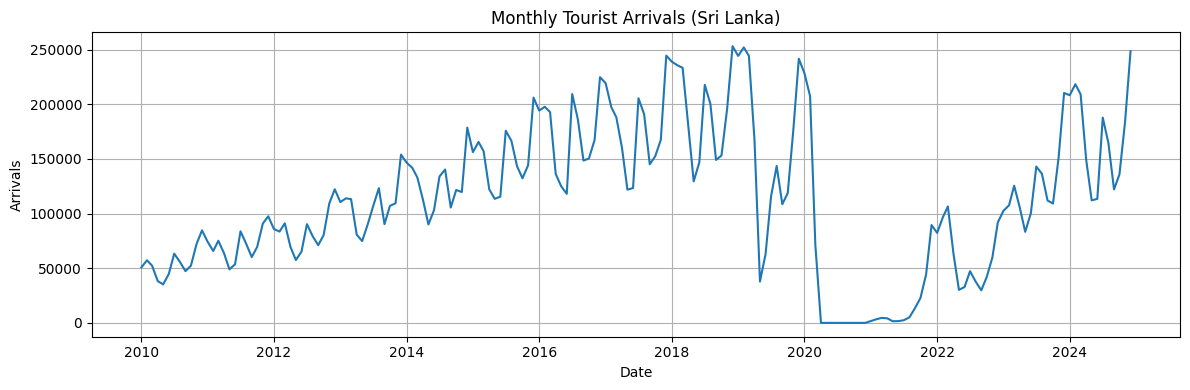

In [5]:
# Plot 1: Tourist arrivals time series
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['tourist_arrivals'])
plt.title('Monthly Tourist Arrivals (Sri Lanka)')
plt.xlabel('Date')
plt.ylabel('Arrivals')
plt.grid(True)
plt.tight_layout()
plt.show()

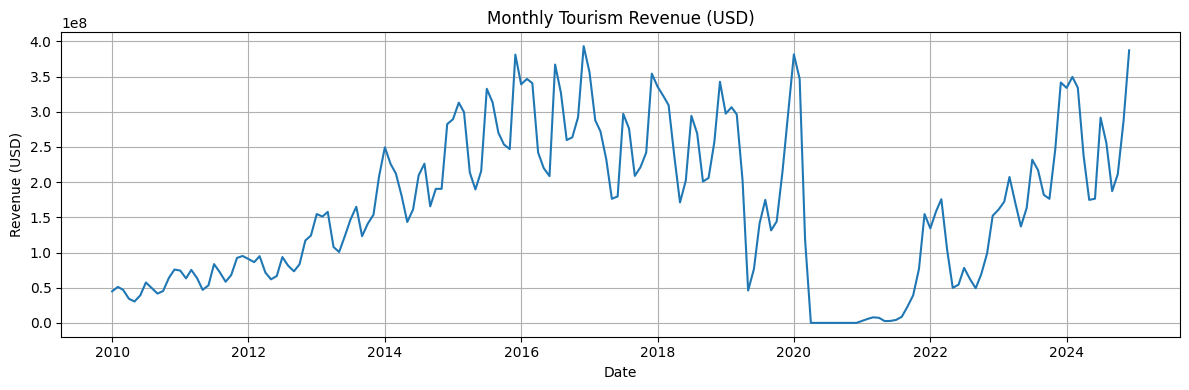

In [6]:
# Plot 2: Tourism revenue time series
plt.figure(figsize=(12,4))
plt.plot(df['date'], df['tourism_revenue_usd'])
plt.title('Monthly Tourism Revenue (USD)')
plt.xlabel('Date')
plt.ylabel('Revenue (USD)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Distribution check

Histogram + kernel density estimate for `avg_daily_spend` using scipy's gaussian_kde

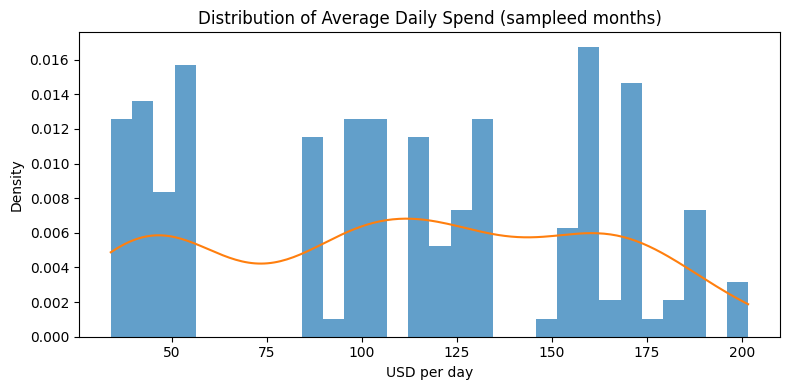

In [7]:
import numpy as np
from scipy.stats import gaussian_kde

series = df.loc[df['avg_daily_spend']>0,'avg_daily_spend'].dropna()

plt.figure(figsize=(8,4))
vals, bins, _ = plt.hist(series, bins=30, density=True, alpha=0.7)
kde = gaussian_kde(series)
x = np.linspace(series.min(), series.max(), 200)
plt.plot(x, kde(x))
plt.title('Distribution of Average Daily Spend (sampleed months)')
plt.xlabel('USD per day')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

### Correlation matrix (numeric variables)

Compute Pearson correlations and plot a matrix view.

                       tourist_arrivals  tourism_revenue_usd  avg_stay  \
tourist_arrivals                   1.00                 0.96      0.17   
tourism_revenue_usd                0.96                 1.00      0.14   
avg_stay                           0.17                 0.14      1.00   
avg_daily_spend                    0.53                 0.55      0.28   
hotel_occupancy_rate               0.65                 0.57      0.27   
exchange_rate_lkr_usd              0.01                 0.08     -0.16   
tourism_employment                 0.98                 0.94      0.13   

                       avg_daily_spend  hotel_occupancy_rate  \
tourist_arrivals                  0.53                  0.65   
tourism_revenue_usd               0.55                  0.57   
avg_stay                          0.28                  0.27   
avg_daily_spend                   1.00                  0.75   
hotel_occupancy_rate              0.75                  1.00   
exchange_rate_lkr_usd  

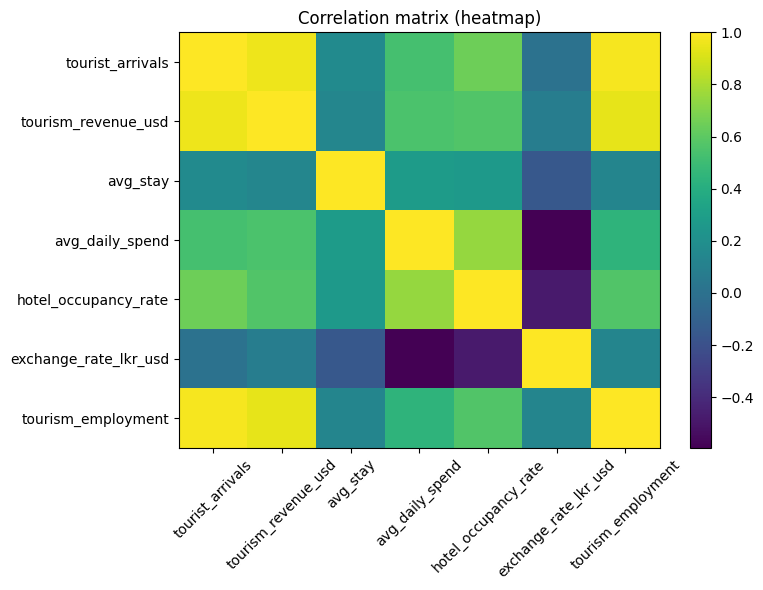

In [8]:
num_cols = ['tourist_arrivals','tourism_revenue_usd','avg_stay','avg_daily_spend','hotel_occupancy_rate','exchange_rate_lkr_usd','tourism_employment']
corr = df[num_cols].corr()
print(corr.round(3))

plt.figure(figsize=(8,6))
plt.imshow(corr, aspect='auto')
plt.colorbar()
plt.xticks(range(len(num_cols)), num_cols, rotation=45)
plt.yticks(range(len(num_cols)), num_cols)
plt.title('Correlation matrix (heatmap)')
plt.tight_layout()
plt.show()

### Save cleaned copy

We save a cleaned version with `date` and `period` columns. Use this in downstream notebooks.

In [9]:
OUT_PATH = Path('../data/tourism_clean.csv')
df.to_csv(OUT_PATH, index=False)
print('Saved cleaned data to', OUT_PATH)

Saved cleaned data to ..\data\tourism_clean.csv
